## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import torch, torch.nn as nn
import torch.nn.functional as F

In [2]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

Файл «sonnets.txt» уже существует — не загружается.



In [3]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it

# Put result into variable text.
text = "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# dict <char>:<index>
token_to_idx = {}
idx_to_token = {}
for idx,token in enumerate(tokens, start = 0):
    token_to_idx[token] = idx
    idx_to_token[idx] = token

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
def to_matrix(names, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [8]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        logits = self.hid_to_logits(h_seq)    
        return F.log_softmax(logits, -1)

In [9]:
# Prepare data
import re
text_split_by_strings = text.split('\n')
text_split_by_4strings= ["".join(text_split_by_strings[i-4:i]) for i in range(4,len(text_split_by_strings),4)]
text_split_by_chapter = re.split("\n\n\s{1,}\w{1,10}\n\n",text)

MAX_LENGTH = max(map(len, text_split_by_strings))
temp = to_matrix(text_split_by_strings, max_len=MAX_LENGTH)
text_split_by_strings_torch = torch.tensor(temp, dtype=torch.int64)

MAX_LENGTH = max(map(len, text_split_by_4strings))
temp = to_matrix(text_split_by_4strings, max_len=MAX_LENGTH)
text_split_by_4strings_torch = torch.tensor(temp, dtype=torch.int64)

MAX_LENGTH = max(map(len, text_split_by_chapter))
temp = to_matrix(text_split_by_chapter, max_len=MAX_LENGTH)
text_split_by_chapter_torch = torch.tensor(temp, dtype=torch.int64)


In [10]:
from IPython.display import clear_output
def train_model(
    model,    
    opt,
    train_torch,
    criterion,
    count_tokens,
    n_iterations=1000,
    batch_size=32,
    show_plots=True,
):    
    history = []
    for i in range(n_iterations):        
        ix = np.random.randint(0, len(train_torch), batch_size)
        batch_ix = train_torch[ix]

        logp_seq = model(batch_ix)
                
        # compute loss
        predictions_logp = logp_seq[:, :-1]# YOUR CODE HERE
        actual_next_tokens = batch_ix[:, 1:]# YOUR CODE HERE

        loss = criterion(
            predictions_logp.contiguous().view(-1, count_tokens),
            actual_next_tokens.contiguous().view(-1)
        ) # YOUR CODE HERE
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        # YOUR CODE HERE
        
        history.append(loss.data.numpy())
        if show_plots:
            if (i+1)%100==0:
                clear_output(True)
                plt.plot(history,label='loss')
                plt.legend()
                plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."    
    

In [11]:
def generate_sample(char_rnn, max_length, tokens,token_to_idx, seed_phrase=' seed', temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)


        # for nn.RNN ...
        #_ = char_rnn(x_sequence[:, :-1])
        #start generating
    for _ in range(max_length - len(seed_phrase)):
            #print(x_sequence.shape, x_sequence, hid_state.shape)
            #out = char_rnn(x_sequence[:, -1:])
            out = char_rnn(x_sequence)
            # Be really careful here with the model output
            p_next = F.softmax(out[:,-1,:] / temperature, dim=-1).data.numpy()[0]
            # sample next token and push it back into x_sequence
            #print(p_next.shape, len(tokens))
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            #print(x_sequence.shape, next_ix.shape)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [12]:
x_sequence = [token_to_idx[token] for token in "good"]
x_sequence = torch.tensor([x_sequence], dtype=torch.int64)


In [13]:
# use nn.RNN
char_rnn_loop = CharRNNLoop()
criterion = nn.NLLLoss()
opt = torch.optim.RMSprop(char_rnn_loop.parameters())

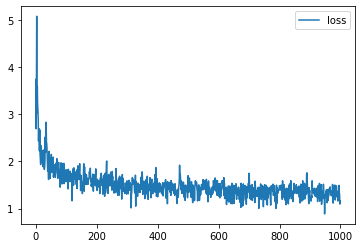

In [14]:
### ОБУЧЕНИЕ НА ЧЕТЕРЫХ СТРОКАХ (ГЛАВЫ без LSTM будут слишком "велики", а построчно обучаться не так эффективно)
train_model(char_rnn_loop, opt, text_split_by_4strings_torch, criterion,len(tokens), n_iterations=1000, batch_size=12)

In [15]:
print(generate_sample(char_rnn_loop,150,tokens,token_to_idx, seed_phrase="help ",temperature=0.1))

help the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t


In [16]:
print(generate_sample(char_rnn_loop,150,tokens,token_to_idx, seed_phrase="help ",temperature=0.2))

help the so the with the the the the the streate the the the the with the the the the the the the of the the the the so the the the the the deart the 


In [17]:
print(generate_sample(char_rnn_loop,150,tokens,token_to_idx, seed_phrase="help ",temperature=0.3))

help the the of that the a and the of the the the the deter the on the then the that the the self the the dest the thee thou the be the the and thou a


In [18]:
print(generate_sample(char_rnn_loop,150,tokens,token_to_idx, seed_phrase="help ",temperature=0.4))

help the the for the of have hand of the of the so farst the with with i that come so and those thee the the love the thou with the worly the will the


In [38]:
print(generate_sample(char_rnn_loop,150,tokens,token_to_idx, seed_phrase="help ",temperature=0.5))

help of to with the the the the it will with mine the with so with that the thou in conk thou in the to the witleft can the the such conce thou thee, 


In [20]:
print(generate_sample(char_rnn_loop,150,tokens,token_to_idx, seed_phrase="help ",temperature=1.0))

help out depeeshow'.    lxx                                                                                                                           


In [21]:
print(generate_sample(char_rnn_loop,150,tokens,token_to_idx, seed_phrase="help ",temperature=2.0))

help liksti'shle, may:  wavy thhedems' fwo dfhibeaulsamy be vw' moun., bonstark'lruveth nowser iscay,:' 'll that:thoneys woad asto meh closdimth'sc'd.


#### Вывод: Наиболее подходящее значение temperature есть 0.5, хотя практически идентично, если определять "на глаз", с 0.4



### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [22]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.lstm(self.emb(x))
        logits = self.hid_to_logits(h_seq)    
        return F.log_softmax(logits, -1)

In [23]:
char_lstm_loop = CharLSTMLoop()
criterion_lstm = nn.NLLLoss()
opt_lstm = torch.optim.RMSprop(char_lstm_loop.parameters())

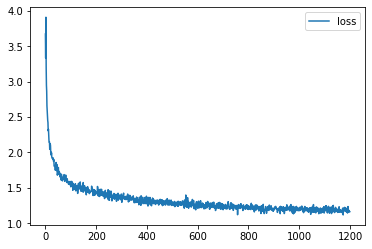

In [24]:
## ОБУЧЕНИЕ НА ГЛАВАХ
train_model(char_lstm_loop, opt_lstm, text_split_by_chapter_torch, criterion_lstm,len(tokens), n_iterations=1200, batch_size=8)

In [25]:
print(generate_sample(char_lstm_loop,500 ,tokens,token_to_idx, seed_phrase="hate ",temperature=0.1))

hate of thee,
    the such me the world the world the world the strange, the world the strange.                                                                                                                                                                                                                                                                                                                                                                                                                     


In [26]:
print(generate_sample(char_lstm_loop,500 ,tokens,token_to_idx, seed_phrase="hate ",temperature=0.2))

hate of thee,
    the sweet for my sake the world the world the world thee i am so thee thee to my love:
    the present the grow'st the counters and the lind,
  the worth the world in the world the present the strange.                                                                                                                                                                                                                                                                                         


In [27]:
print(generate_sample(char_lstm_loop,500 ,tokens,token_to_idx, seed_phrase="hate ",temperature=0.3))

hate of thee:
    the strangsured by thy sweet shall doth me the world thee hand,
  thou art the worst the worlds in the strangely prove thee thee,
    the complay's worse the world and the world and the sun,
  and with my love the truth in the hours to my grow
  and so sweet love the strangely is spirit,
  when i do i have summer strangely with the strange,
  that the world with this with and with sweet be thee,
    and heart the world thou art the world the lease the created did make
  the cou


In [36]:
print(generate_sample(char_lstm_loop,500 ,tokens,token_to_idx, seed_phrase="hate ",temperature=0.4))

hate the present dear,
  the sweet that thou art the right, and should i dear derair,
  the wornd his proud that beauty doth his perfect,
  when i am false my self to thee,
  to be a dater so shows of thy self art love,
  the worst the world the doth perjur'd to thee,
  when i am so sweet thee with a their dear desert belove.
  the strangst that i see thee like in thee,
  the thing that thou art that shall still, and his present bear now.
  so the report the canst my not the strong,
  thou to th


In [29]:
print(generate_sample(char_lstm_loop,500 ,tokens,token_to_idx, seed_phrase="hate ",temperature=0.5))

hate of my heart,
    and was i do not love the truly the deeds, so breathed heart,
  what sweet in the right they thy sweet doth deceased,
    for the perfection thee with me the true not show,
    and so the black with my mistress to show dwanting thee,
  and the worth the beauty did can see
  when thou wilt thee not to wint to dre so so praise.
  o! thy meartary in the offery someting from thee.
    so in thy sweet sweetest me winter that do i sings me,
    and so the world in thy sweet far t


In [30]:
print(generate_sample(char_lstm_loop,500 ,tokens,token_to_idx, seed_phrase="hate ",temperature=1))

hate two thee in every eye:
  that in thy sweet as dost the lind,
  with grow'st other it them unble me,
  with tire the as pleasures i think in thee.
  then, blunt most of thy love to have part frome
  and this pamest not sins truth his writh to my main;
  that every are thou are both nature's finding.
    i due alll not o! fanseld, which he'full: this worthy where stand.                                                                                                                             


In [31]:
print(generate_sample(char_lstm_loop,500 ,tokens,token_to_idx, seed_phrase="hate ",temperature=2))

hate cwer;
  borms will isflivsid! a-so
 wid:-banqus-mani's mounw?'y
  tyry seiss.                                                mo! mins eytly vany and gpotptawesn sparp to baqus vilanks nrme: ago,
  no, and didyarddst, at in al a)olve, yrtanch fidutess unkippy my figh,
  migitu, in my lazewed copandizucs,
  threitfiou! wing's knitnale.:-
    hoatt me oblranty,--and mouwh make, let rendaimsiep'ers';
  ill;
 loy, joy worlg'd mets, thours, hel!
  timicy of, them frein, burn of feir, v'dq,ul;
  b


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

#### Вывод: Наиболее подходящее значение temperature есть 0.5, хотя 0.4 и 1 тоже неплохи

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [33]:
torch.save(char_lstm_loop,"model_lstm")

/Users/workhard/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharLSTMLoop. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [34]:
model = torch.load("model_lstm")
model.eval()

CharLSTMLoop(
  (emb): Embedding(38, 16)
  (lstm): LSTM(16, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=38, bias=True)
)

In [35]:
print(generate_sample(model,500 , tokens,token_to_idx,seed_phrase="help ",temperature=0.5))

help his made thee thou art desert's waste
  the might i do not the deceives,
  they self with shall proud in the rich i dead,
    to make and all thy love there by the linds in thee,
    and the worth to my gelle me grow do i will knows not remember'd.
  the confeds then i dear my fair and his i do i hose in thee will;
  but i have see thee me thee the strength the winds with from thee:
    the too as thine the world being for the praise thee:
    for the worth of thy tongues to the beauty's lo


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)